cuda
True
SUCCESS


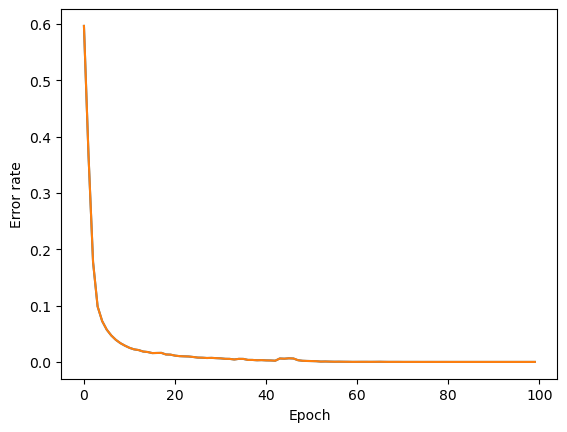

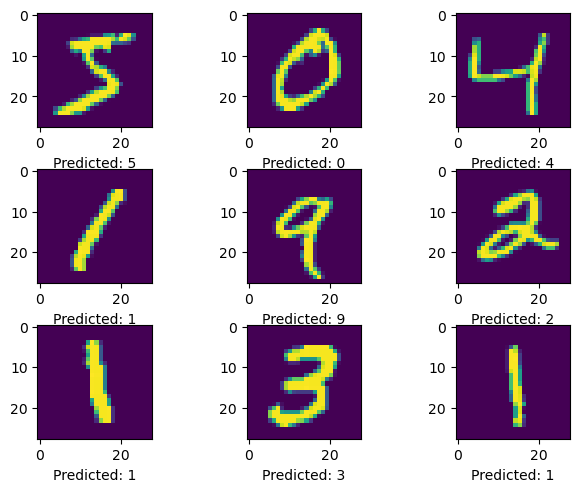

In [14]:
import numpy as np
from matplotlib import pyplot as plt
import torch
from torch.utils.data import DataLoader, TensorDataset

# Load the MNIST dataset
from torchvision.datasets import MNIST

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

#Force CPU
forceCPU = False
if forceCPU:
    device=torch.device("cpu")
print(device)

dataset = MNIST(root='.', download=True)

print(torch.cuda.is_available())

# Preprocess the data
#Lin
# X_train = dataset.train_data.numpy().reshape((-1, 28*28)) / 255.0
# X_test = dataset.test_data.numpy().reshape((-1, 28*28)) / 255.0

#Conv
X_train = dataset.train_data.numpy().reshape(-1,1,28,28) / 255.0
X_test = dataset.test_data.numpy().reshape(-1,1,28,28) / 255.0


y_train = dataset.train_labels.numpy()
y_test = dataset.test_labels.numpy()

# Convert the labels to one-hot encoded vectors
y_train = np.eye(10)[y_train]
y_test = np.eye(10)[y_test]

cudaxTrain = torch.tensor(X_train, dtype=torch.float, device=device)
cudayTrain = torch.tensor(y_train, dtype=torch.float, device=device)

cudaxVal = torch.tensor(X_test, dtype=torch.float, device=device)
cudayVal = torch.tensor(y_test, dtype=torch.float, device=device)

BATCHSIZE = 10000
dataset = TensorDataset(cudaxTrain,cudayTrain)
dataloader = DataLoader(dataset=dataset, batch_size=BATCHSIZE, shuffle=True)

# Create the neural network
class Net(torch.nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        #Fully Connected
        # self.fc1 = torch.nn.Linear(28*28, 128)
        # self.fc2 = torch.nn.Linear(128, 256)
        # self.fc3 = torch.nn.Linear(256, 128)
        # self.fc4 = torch.nn.Linear(128, 10)

        
        self.cv = torch.nn.Sequential(
            torch.nn.Conv2d(in_channels=1, out_channels=3, kernel_size=5, padding=2),
            torch.nn.ReLU(),
            torch.nn.MaxPool2d(2, 2),
            
            torch.nn.Conv2d(in_channels=3, out_channels=8, kernel_size=5, padding=2),
            torch.nn.ReLU(),
            torch.nn.MaxPool2d(2,2)
        )

        self.fc = torch.nn.Sequential(
            torch.nn.Linear(392, 392),
            torch.nn.ReLU(),
            torch.nn.Linear(392, 196),
            torch.nn.ReLU(),
            torch.nn.Linear(196, 10)
        )

        
    

    def forward(self, x):
        # x = torch.nn.functional.relu(self.fc1(x))
        # x = torch.nn.functional.relu(self.fc2(x))
        # x = torch.nn.functional.relu(self.fc3(x))
        # x = self.fc4(x)
        x = self.cv(x)
        x = x.view(x.size(0), -1)
        x = self.fc(x)
        
        # x = self.cv2(x)
        return x




model = Net()
model.to(device)
model(cudaxTrain)

print("SUCCESS")

# Define the loss function and optimizer
loss_fn = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
numEpochs = 60
history = np.zeros(shape=(numEpochs), dtype=float)
errorRate = np.zeros(shape=(numEpochs), dtype=float)
indexRange = torch.arange(cudayVal.shape[0])
indexRangeTrain = torch.arange(cudayTrain.shape[0])
# Train the model
for epoch in range(numEpochs):

    for idx, (x_batch,y_batch) in enumerate(dataloader):
        # Forward pass
        outputs = model(x_batch)
        loss = loss_fn(outputs, y_batch)

        # Backward pass
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    #/////////////////////

    #Forward pass
    # outputs = model(torch.tensor(X_train, dtype=float))
    # loss = loss_fn(outputs, y_batch)

    # # Backward pass
    # optimizer.zero_grad()
    # loss.backward()
    # optimizer.step()

    #///////////////////////

    #Calculate error rate
    valPred = model(cudaxVal)
    valPred = torch.argmax(valPred,dim=1)
    correct = cudayVal[indexRange,valPred]
    numCorrect = 1-(torch.sum(correct).item() / cudayVal.shape[0])

    errorRate[epoch] = numCorrect

    #Calculate error rate on training set

    valPred = model(cudaxTrain)
    valPred = torch.argmax(valPred,dim=1)
    correct = cudayTrain[indexRangeTrain,valPred]
    numCorrect = 1-(torch.sum(correct).item() / cudayTrain.shape[0])

    
    history[epoch] = numCorrect
    print("Epoch:"+str(epoch), end="\r")

torch.save(model.state_dict(), "MNISTtrainedModel.pt")

#Plot the error rate
plt.plot(history)
plt.plot(errorRate)
plt.xlabel('Epoch')
plt.ylabel('Error rate')
plt.show()

model.eval()
fig, ax = plt.subplots(3,3)
ax = ax.flatten()
fig.tight_layout(pad=0.9)

X_test = X_test.reshape(-1,28,28)
xValPred = model(cudaxVal)
xValPred = xValPred.cpu().detach().numpy()
for x in range(9):
    test = X_test[x]
    ax[x].imshow(test)
    ax[x].set_xlabel("Predicted: " + str(np.argmax(xValPred[x])))



In [ ]:
import numpy as np
from matplotlib import pyplot as plt

a = np.arange(100, dtype=float)
plt.plot(a)
plt.show()

In [ ]:
import numpy as np
import torch
import torchvision
torch.cuda.is_available()